# Visualising high-dimensional datasets using PCA and t-SNE in Python
https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

- ほとんどのデータセットは多数の変数を持っています。言い換えれば、データが分布している次元の数が多いということです。
- そのため、データを視覚的に探索することは困難であり、ほとんどの場合、手動で行うことは実質的に不可能です。
- しかし、このような視覚的な探索は、データ関連の問題において非常に重要です。
- したがって、高次元のデータセットをどのように視覚化するかを理解することが重要です。
- これは、次元削減として知られているテクニックを使って達成することができます。
- 以下では、これを可能にする2つの技術として、PCAとt-SNEに焦点を当てます。

In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd

# from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

/Users/hiroyasu.komaki/myGithub/jupyter_notebook/cluster_analysis/.venv/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## MNIST dataset

In [2]:
mnist = fetch_openml('mnist_784', version=1,)

In [3]:
X = mnist.data / 255.0
y = mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


In [4]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)

df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 786)


In [5]:
# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

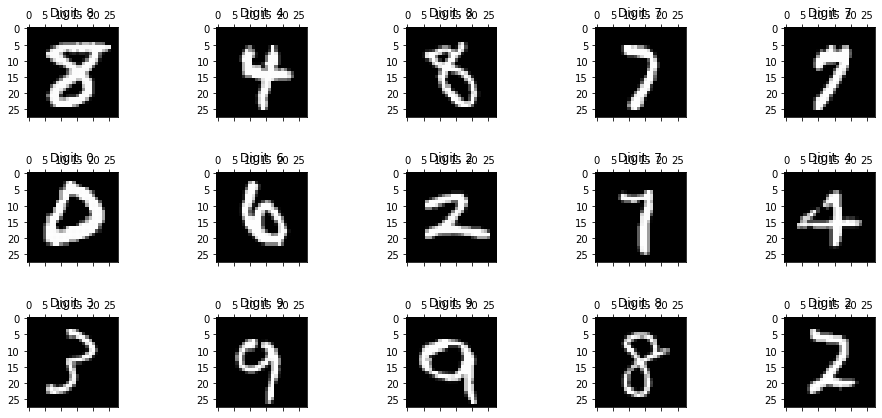

In [6]:
plt.gray()

fig = plt.figure( figsize=(16,7) )
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
    
plt.show()

## Dimensionality reduction using PCA

- PCAは，ほとんどの情報を保持しつつ，データセットの次元数を減らすための手法である
- いくつかの次元間の相関を使用しており、元のデータがどのように分布しているかについての変動の最大量または情報を保持する変数の最小数を提供しようとします。
- これは、推測ではなく、難しい数学を使用して、データ行列の固有値と固有ベクトルとして知られているものを使用します。
- 共分散行列のこれらの固有ベクトルは、データの変動の主要な方向に沿って指すという特性を持っています。
- これらは，データセットにおける最大の変動の方向である私たち人間は2次元や3次元のプロットが好きなので、それから始めて、元の784次元から、- 

In [7]:
# 最初の3つの主成分を生成
pca = PCA(n_components=3)

pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


- 第1と第2の主成分の散布図を作成し、異なるタイプの数字のそれぞれに異なる色をつけます。
- 運が良ければ、同じ種類の数字がグループになって配置される（つまり、クラスタ化される）ことになり、最初の2つの主成分が特定の数字の種類について多くのことを教えてくれます。

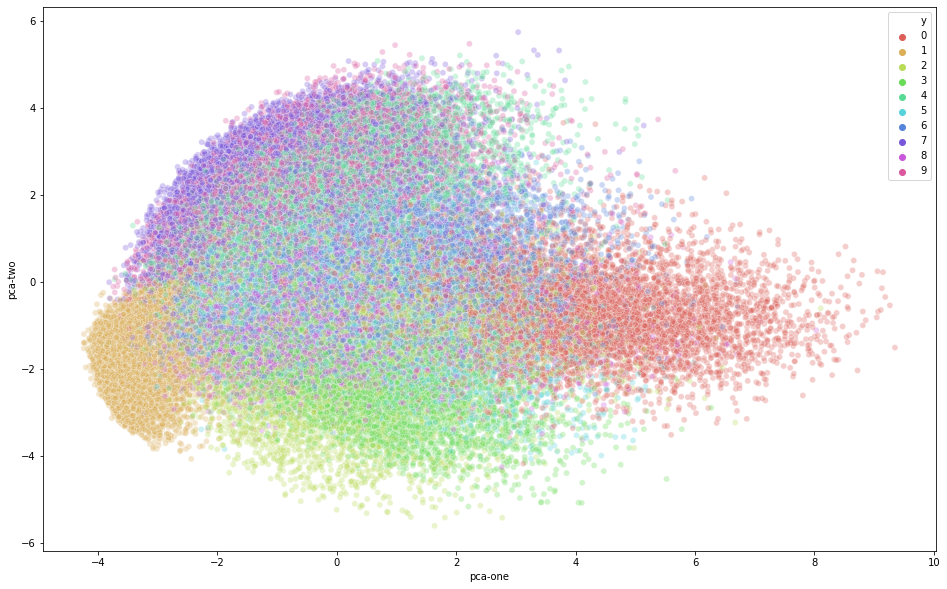

In [8]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

- グラフを見ると、2つの成分は間違いなく、特に特定の桁についての情報を保持していることがわかりますが、それらすべてを区別するには明らかに十分ではありません。
- 幸いなことに、次元の数を減らすのに使える別のテクニックがあります。
- 次の数段落では、そのテクニックを見ていき、可視化のための次元数を減らすためのより良い方法があるかどうかを探っていきます。
- 今回探索する手法は、t-SNE（t-Distributed Stochastic Neighbouring Entities）として知られています。

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

- t-Distributed Stochastic Neighbor Embedding (t-SNE)は、次元削減のためのもう一つの手法であり、高次元データセットの可視化に特に適しています。
- PCAとは異なり、これは数学的な手法ではなく、確率論的な手法です。
- これが意味するところは、アルゴリズムに入力された元のデータを見て、両方の分布を一致させることで、より少ない次元でこのデータを最適に表現する方法を検討するということです。
- この方法は計算量が非常に多く、したがって、この手法の使用にはいくつかの深刻な制限があります。
- 例えば、非常に高い次元のデータの場合には、t-SNEを使用する前に別の次元削減技術を適用する必要があるかもしれないということです。

- 上記の推奨に反して、まずデータの実際の次元(784)でアルゴリズムを実行してみて、その結果を見てみます。
- メモリと電力/時間の点でマシンに負担をかけないことを確認するために、アルゴリズムを実行するために最初の 10,000 サンプルだけを使用します。
- 後で比較するために、サブセットで再度PCAを実行します。

In [16]:
N = 10000

df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09819946 0.07123677 0.06113222]


In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.621s...
[t-SNE] Computed neighbors for 10000 samples in 154.925s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.117975
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.844635
[t-SNE] KL divergence after 300 iterations: 2.786723
t-SNE done! Time elapse

- 結果として2つの次元が得られたので、2つの次元の散布図を作成し、各標本にそれぞれのラベルで色をつけることで、再びそれらを可視化することができます。

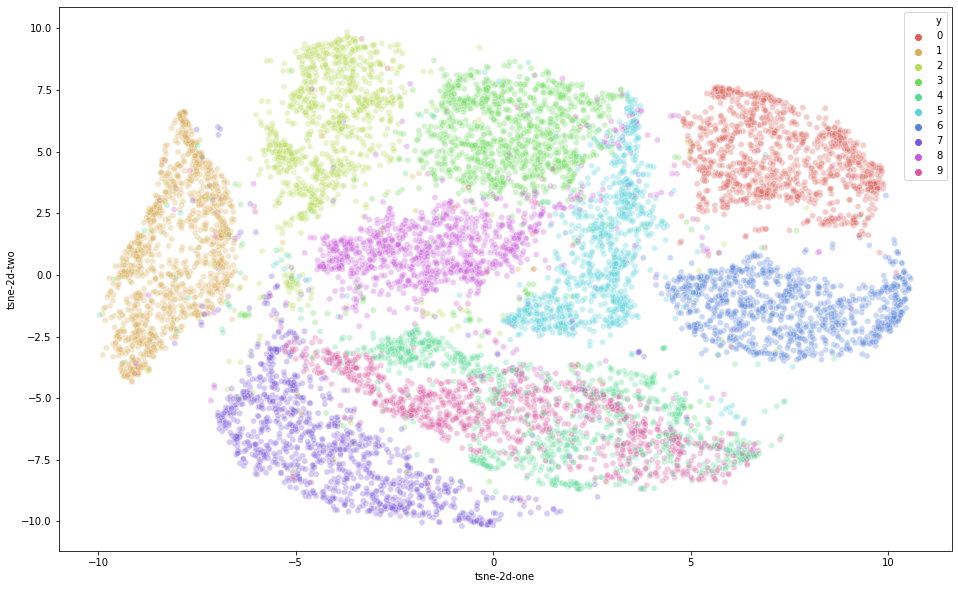

In [18]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

- これは、以前に使用したPCAビジュアライゼーションよりもすでに大幅に改善されています。
- 桁がそれぞれのサブグループに明確にクラスタリングされていることがわかります。
- 分離したクラスタを選択するためにクラスタリング・アルゴリズムを使用するならば、おそらくラベルに新しいポイントをかなり正確に割り当てることができるでしょう。
- PCAとT-SNEを比較してみましょう。

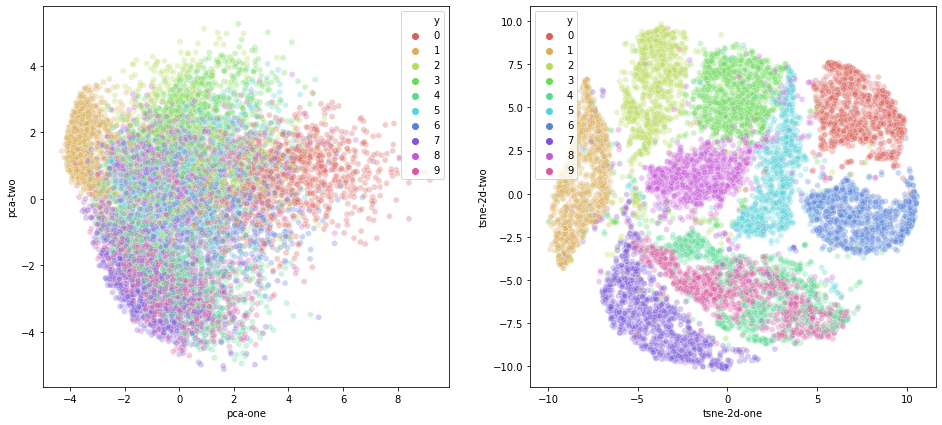

In [19]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

- 我々は今、推奨事項を心に留め、実際にt-SNEアルゴリズムにデータを入力する前に次元の数を減らします。
- このために、我々は再びPCAを使用します。
- まず、PCA削減アルゴリズムによって生成された50の次元を含む新しいデータセットを作成します

In [20]:
# 事前にPCAで次元削減
pca_50 = PCA(n_components=50)

pca_result_50 = pca_50.fit_transform(data_subset)

print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8261610590761397


- 驚くべきことに、最初の50のコンポーネントは、データ内の総変動の約85％を保持しています。
- 今、試してみて、このデータを t-SNE アルゴリズムに投入してみましょう。
- 今回は、アルゴリズムがあまりにも多くのメモリとCPUを消費しないことを確認するために、70,000のうち10,000のサンプルを使用します。

In [40]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 22.95259404182434 seconds


- このプロットから、すべてのサンプルがきれいに間隔をあけて、それぞれの数字と一緒にグループ化されていることがはっきりとわかります。
- これは、クラスタリング・アルゴリズムを使用してクラスタを識別したり、別のアルゴリズム（例えば、ニューラル・ネットワークのようなもの）への入力としてこれらの2次元を実際に使用したりするための素晴らしい出発点になるでしょう。
- そこで我々は、二次元散布図を用いて高次元データを可視化するために、様々な次元削減技術を使用してみました。
- ここでは実際の数学には触れず、すべてのアルゴリズムのScikit-Learnの実装に頼っています。

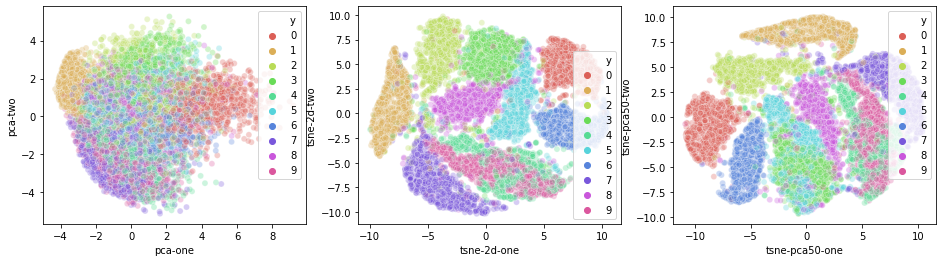

In [41]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)